In [1]:
import torch


def load_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )

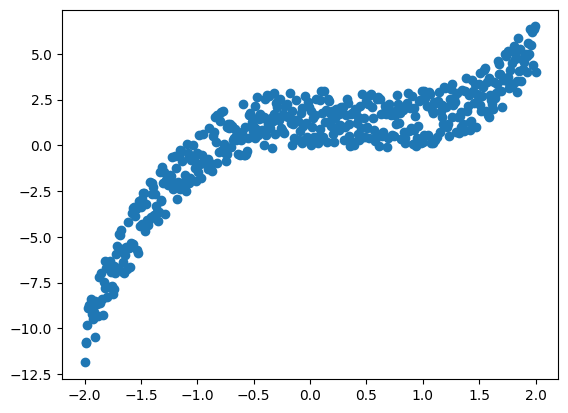

In [2]:
import matplotlib.pyplot as plt

# generate data

x = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [3]:
# make dataloader of data
import torch.utils.data as Data

torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
)

In [9]:
# Pre-trained model
model = load_model()

# get the information of the model
for name, param in model.named_parameters():
    print(name, param.size())

model.named_parameters()
    

0.weight torch.Size([50, 1])
0.bias torch.Size([50])
2.weight torch.Size([1, 50])
2.bias torch.Size([1])


<generator object Module.named_parameters at 0x17e4ad840>

In [13]:
from laplace import Laplace



# Examples of different ways to specify the subnetwork
# via indices of the vectorized model parameters
#
# Example 1: select the 128 parameters with the largest magnitude
# from laplace.utils import LargestMagnitudeSubnetMask
# subnetwork_mask = LargestMagnitudeSubnetMask(model, n_params_subnet=128)
# subnetwork_indices = subnetwork_mask.select()

# Example 2: specify the layers that define the subnetwork
# from laplace.utils import ModuleNameSubnetMask
# subnetwork_mask = ModuleNameSubnetMask(model, module_names=['layer.0'])
# subnetwork_mask.select()
# subnetwork_indices = subnetwork_mask.indices

# Example 3: manually define the subnetwork via custom subnetwork indices
# import torch
# subnetwork_indices = torch.tensor([0, 4, 11, 42, 123, 2021])

# Define and fit subnetwork LA using the specified subnetwork indices
la = Laplace(model, 'regression',
             subset_of_weights='last_layer',
             hessian_structure='diag')
la.fit(loader)

In [ ]:
# Compute the Laplace approximation of the model
# using the fitted subnetwork LA




In [31]:
import torch.utils.data as data_utils 

def generate_data(n_samples=150, noise=0.1, batch_size=150):
    torch.manual_seed(711)
    x = torch.linspace(-2, 2, n_samples)
    y = x.pow(3) - x.pow(2) + noise*torch.randn(x.size())
    x_train = torch.unsqueeze(x, dim=1)
    y_train = torch.unsqueeze(y, dim=1)
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(x_train, y_train), 
        batch_size=batch_size
    )
    x_test = torch.linspace(-2, 2, 100).unsqueeze(-1)
    return x_train, y_train, train_loader, x_test


In [32]:
X_train, y_train, train_loader, X_test = generate_data()

In [14]:
import torch.utils.data as data_utils 

def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test


In [15]:
# create toy regression data
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

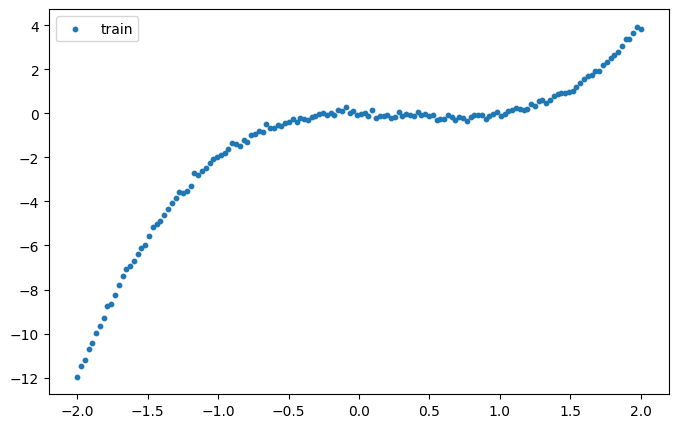

In [33]:
# plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, s=10, label='train')
plt.legend()
plt.show()

In [17]:
def plot_regression(X_train, y_train, X_test, f_test, y_std, plot=True, 
                    file_name='regression_example'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                figsize=(4.5, 2.8))
    ax1.set_title('MAP')
    ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax1.plot(X_test, f_test, color='black', label='$f_{MAP}$')
    ax1.legend()

    ax2.set_title('LA')
    ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax2.plot(X_test, f_test, label='$\mathbb{E}[f]$')
    ax2.fill_between(X_test, f_test-y_std*2, f_test+y_std*2, 
                     alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[y]}$')
    ax2.legend()
    ax1.set_ylim([-4, 6])
    ax1.set_xlim([X_test.min(), X_test.max()])
    ax2.set_xlim([X_test.min(), X_test.max()])
    ax1.set_ylabel('$y$')
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    plt.tight_layout()
    plt.show()
    # if plot:
    #     plt.show()
    # else:
    #     plt.savefig(f'docs/{file_name}.png')

sigma=0.38 prior precision=7.15


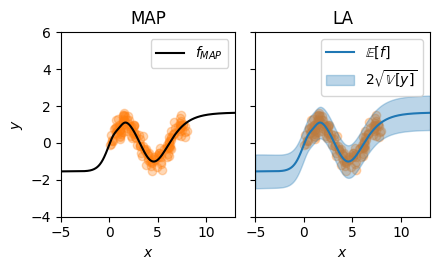

In [21]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training


n_epochs = 1000
torch.manual_seed(711)

# construct single layer neural network
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

# train MAP
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='diag')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

print(f'sigma={la.sigma_noise.item():.2f}',
      f'prior precision={la.prior_precision.item():.2f}')

x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)  

f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().detach().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std, 
                file_name='regression_example', plot=False)

sigma=0.13 prior precision=2.48


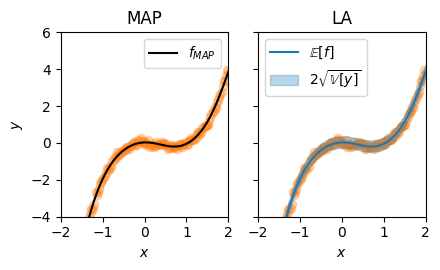

In [34]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training


n_epochs = 1000
torch.manual_seed(711)

# construct single layer neural network
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

# train MAP
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='diag')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

print(f'sigma={la.sigma_noise.item():.2f}',
      f'prior precision={la.prior_precision.item():.2f}')

x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)  

f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().detach().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std, 
                file_name='regression_example', plot=False)

# Classification problem